# `strategic-fl-sim`: FEMNIST Demo Experiment 

Demonstrating strategic federated learning with adversarial client who upscales their updates

In [ ]:
import json
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch

# Import framework components
from femnistdataset import FEMNISTDataset
from torch import nn
from torch.utils.data import DataLoader

from models import CNN
from strategicflsim.agents import Client, Server
from strategicflsim.utils.actions import create_scalar_action
from strategicflsim.utils.aggregation import get_aggregate
from strategicflsim.utils.evaluate import evaluate_with_ids
from strategicflsim.utils.metrics import get_gradient_metrics

/Users/dimitar-chakarov/Documents/projects/strategicfl/fl/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparation/initialization

### Setup device

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # GPU
elif torch.backends.mps.is_built():
    device = torch.device("mps")  # Apple M-series
else:
    device = torch.device("cpu")  # CPU

print(f"Using device: {device}")

Using device: mps


### Setup experiment configuration

In [5]:
config = {
    "training": {
        "T": 3500,  # Number of training rounds
        "lr": 0.06,  # Learning rate
        "local_steps": 3,  # Local SGD steps
        "batch_size": 32,
        "eval_batch_size": 64,
    },
    "clients": {
        "n_players": 10,  # Number of client groups
        "alpha_0": 1.0,  # Good client scaling
        "alpha_1": 2.0,  # Bad client scaling; Not really bad here, this is for illustrative purposes of the functionality of the package
        "beta_0": 0.0,  # Honest client noise
        "beta_1": 0.0,  # Adversarial client noise
    },
    "aggregation": {
        "method": "mean"  # Can be 'mean', 'median', 'trimmed_mean'
    },
    "data": {
        "train_path": "../../data/femnist/train.json",
        "test_path": "../../data/femnist/test.json",
    },
}

print("Configuration:")
for section, values in config.items():
    print(f"  {section}:")
    for key, value in values.items():
        print(f"    {key}: {value}")

Configuration:
  training:
    T: 3500
    lr: 0.06
    local_steps: 3
    batch_size: 32
    eval_batch_size: 64
  clients:
    n_players: 10
    alpha_0: 1.0
    alpha_1: 2.0
    beta_0: 0.0
    beta_1: 0.0
  aggregation:
    method: mean
  data:
    train_path: ../../data/femnist/train.json
    test_path: ../../data/femnist/test.json


### Loading the FEMNIST data

In [6]:
def get_data(path: str):
    with open(path, "r") as f:
        data = json.load(f)
        user_names = list(data.keys())
    return data, user_names


print("\nLoading FEMNIST data...")
data_dict, user_names = get_data(config["data"]["train_path"])
test_data_dict, _ = get_data(config["data"]["test_path"])

print(f"Training data: {len(user_names)} users")
print(f"Sample user data size: {len(data_dict[user_names[0]]['x'])} samples")


Loading FEMNIST data...
Training data: 3597 users
Sample user data size: 139 samples


### Creating a Server agent with CNN model

In [7]:
print("\nCreating server...")
server_model = CNN().to(device)

# Enable compilation for better performance (if available)
if device.type == "cuda":
    server_model = torch.compile(server_model, mode="reduce-overhead")

server = Server(
    device=device,
    model=server_model,
    criterion=nn.CrossEntropyLoss().to(device),
    optimizer=torch.optim.SGD(server_model.parameters(), lr=config["training"]["lr"]),
    aggregate_fn=get_aggregate(method=config["aggregation"]["method"]),
)

print(f"Created server with {config['aggregation']['method']} aggregation")


Creating server...
Created server with mean aggregation


### Creating a group of Client agents
All but one clients are honest, one client is scaling up their update.

In [8]:
print("\nCreating clients...")
split_index = len(user_names) // config["clients"]["n_players"]
clients = []

for i in range(config["clients"]["n_players"]):
    # Split users among clients
    start_idx = max(0, i * split_index)
    end_idx = min((i + 1) * split_index, len(user_names))
    client_user_names = user_names[start_idx:end_idx]

    # Last client is adversarial, others are honest
    if i == config["clients"]["n_players"] - 1:
        alpha = config["clients"]["alpha_1"]
        beta = config["clients"]["beta_1"]
        agent_id = "bad"
        print(f"  Client {i + 1}: BAD")
    else:
        alpha = config["clients"]["alpha_0"]
        beta = config["clients"]["beta_0"]
        agent_id = f"good{i}"
        print(f"  Client {i + 1}: GOOD")

    # Create datasets
    train_dataset = FEMNISTDataset(client_user_names, data_dict)
    test_dataset = FEMNISTDataset(client_user_names, test_data_dict)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config["training"]["batch_size"],
        shuffle=True,
        pin_memory=True if device.type == "cuda" else False,
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=config["training"]["eval_batch_size"],
        shuffle=False,
        pin_memory=True if device.type == "cuda" else False,
    )

    # Create client model
    client_model = CNN().to(device)
    if device.type == "cuda":
        client_model = torch.compile(client_model, mode="reduce-overhead")

    client = Client(
        device=device,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        model=client_model,
        criterion=nn.CrossEntropyLoss().to(device),
        optimizer=torch.optim.SGD(
            client_model.parameters(), lr=config["training"]["lr"]
        ),
        action=create_scalar_action(alpha, beta),
        agent_id=agent_id,
    )

    clients.append(client)


Creating clients...
  Client 1: GOOD
  Client 2: GOOD
  Client 3: GOOD
  Client 4: GOOD
  Client 5: GOOD
  Client 6: GOOD
  Client 7: GOOD
  Client 8: GOOD
  Client 9: GOOD
  Client 10: BAD


## Run federated training

In [9]:
print(f"\nStarting federated training for {config['training']['T']} rounds...")

all_losses, all_metrics = server.train(
    clients=clients,
    T=config["training"]["T"],
    get_metrics=get_gradient_metrics,
)

print("Training completed!")


Starting federated training for 3500 rounds...


Federated Training: 100%|██████████| 3500/3500 [08:41<00:00,  6.71it/s]

Training completed!


## Evaluate final performance

In [11]:
print("\nEvaluating final performance...")
final_accuracy, final_loss = evaluate_with_ids(server, clients)


Evaluating final performance...
good0: Accuracy = 0.8535, Loss = 0.4236
good1: Accuracy = 0.8205, Loss = 0.5187
good2: Accuracy = 0.8104, Loss = 0.5556
good3: Accuracy = 0.8285, Loss = 0.5216
good4: Accuracy = 0.8384, Loss = 0.4784
good5: Accuracy = 0.8661, Loss = 0.4175
good6: Accuracy = 0.9017, Loss = 0.3134
good7: Accuracy = 0.8391, Loss = 0.4902
good8: Accuracy = 0.8408, Loss = 0.4830
bad: Accuracy = 0.8622, Loss = 0.4137


## Visualize training process

Figure saved as 'femnist_training_metrics.png'


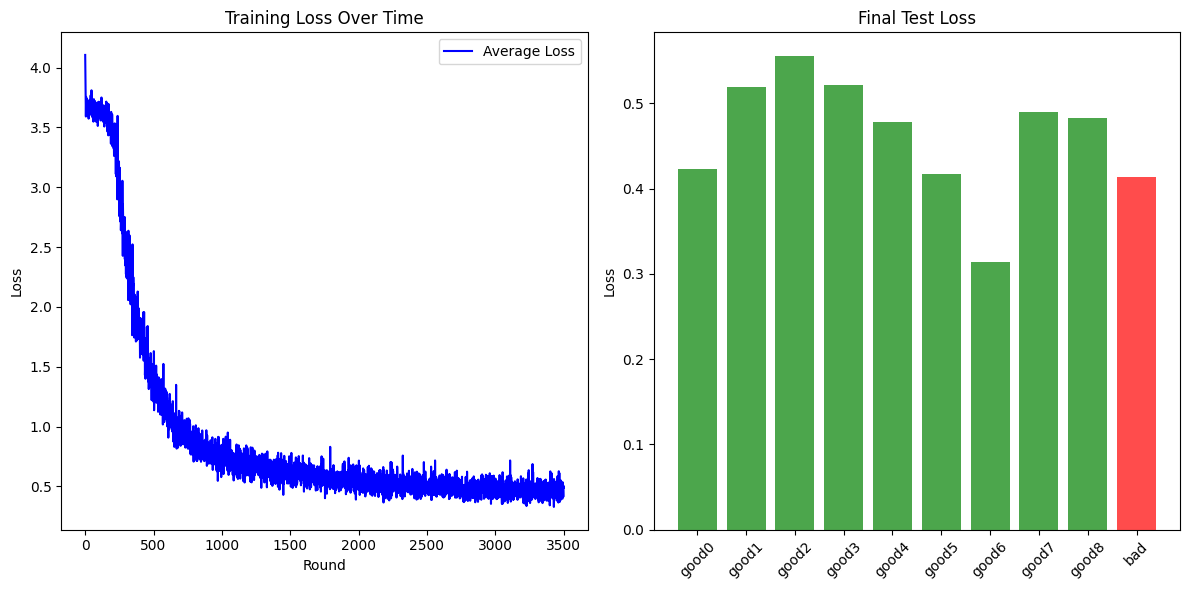

In [ ]:
losses_array = np.array(
    [[loss for loss in round_losses] for round_losses in all_losses]
)
grad_norms_array = np.array([metrics["grad_norms"] for metrics in all_metrics])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Training losses over time
axes[0].plot(losses_array.mean(axis=1), label="Average Loss", color="blue")

axes[0].set_title("Training Loss Over Time")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Final loss bar plot
client_ids = list(final_loss.keys())
loss = [float(final_loss[client_id]) for client_id in client_ids]
colors = [
    "red"
    if "adversarial" in client_id.lower() or "bad" in client_id.lower()
    else "green"
    for client_id in client_ids
]
axes[1].bar(client_ids, loss, color=colors, alpha=0.7)
axes[1].set_title("Final Test Loss")
axes[1].set_ylabel("Loss")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()

# Save the figure to file
fig_filename = 'femnist_training_metrics'
plt.savefig(f'{fig_filename}.png', dpi=300, bbox_inches='tight')
print(f"Figure saved as '{fig_filename}.png'")

plt.show()

### [Optional] Saving the results

In [ ]:
results = {
    "config": config,
    "final_accuracy": final_accuracy,
    "final_loss": final_loss,
    "training_losses": losses_array,
    "gradient_norms": grad_norms_array,
}

with open("strategicflsim_demo_femnist.pkl", "wb") as f:
    pickle.dump(results, f)
print("Results saved to strategicflsim_demo_femnist.pkl")